## Creating a fragment library from fragments

To create a fragment library, we need a fragment db. You can create a fragment db from a given list of SMILES using 'CReM' - https://github.com/DrrDom/crem. We used a fragment db generated from a list of ZINC molecules for this tutorial. The goal of this tutorial is to select fragments that are appropriate for fragment-based generation. 

In [1]:
import sqlite3
import pandas as pd 
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

First, we open the fragment db using sqlite.

In [2]:
connection = sqlite3.connect("fragments.db")
cur = connection.cursor()

Then, we query fragments in given condition. Here, we only consider fragments that appear at least twice in the db ('freq > 1'). 

In [3]:
radius = 2
min_atoms, max_atoms = 1, 16
sql = f"""SELECT core_smi
          FROM radius{radius}
          WHERE core_num_atoms BETWEEN ? AND ?
          AND freq > 1"""
cur.execute(sql, (min_atoms, max_atoms))
motifs = cur.fetchall()
len(list(motifs)), len(set(list(motifs)))

(1145, 825)

In [4]:
frag_samples = [[l[0], Chem.MolFromSmiles(l[0])] for l in list(set(motifs))]
frag_samples = pd.DataFrame(frag_samples).set_axis(['frag', 'mol'], axis=1, inplace=False)

Let's take a look on some...

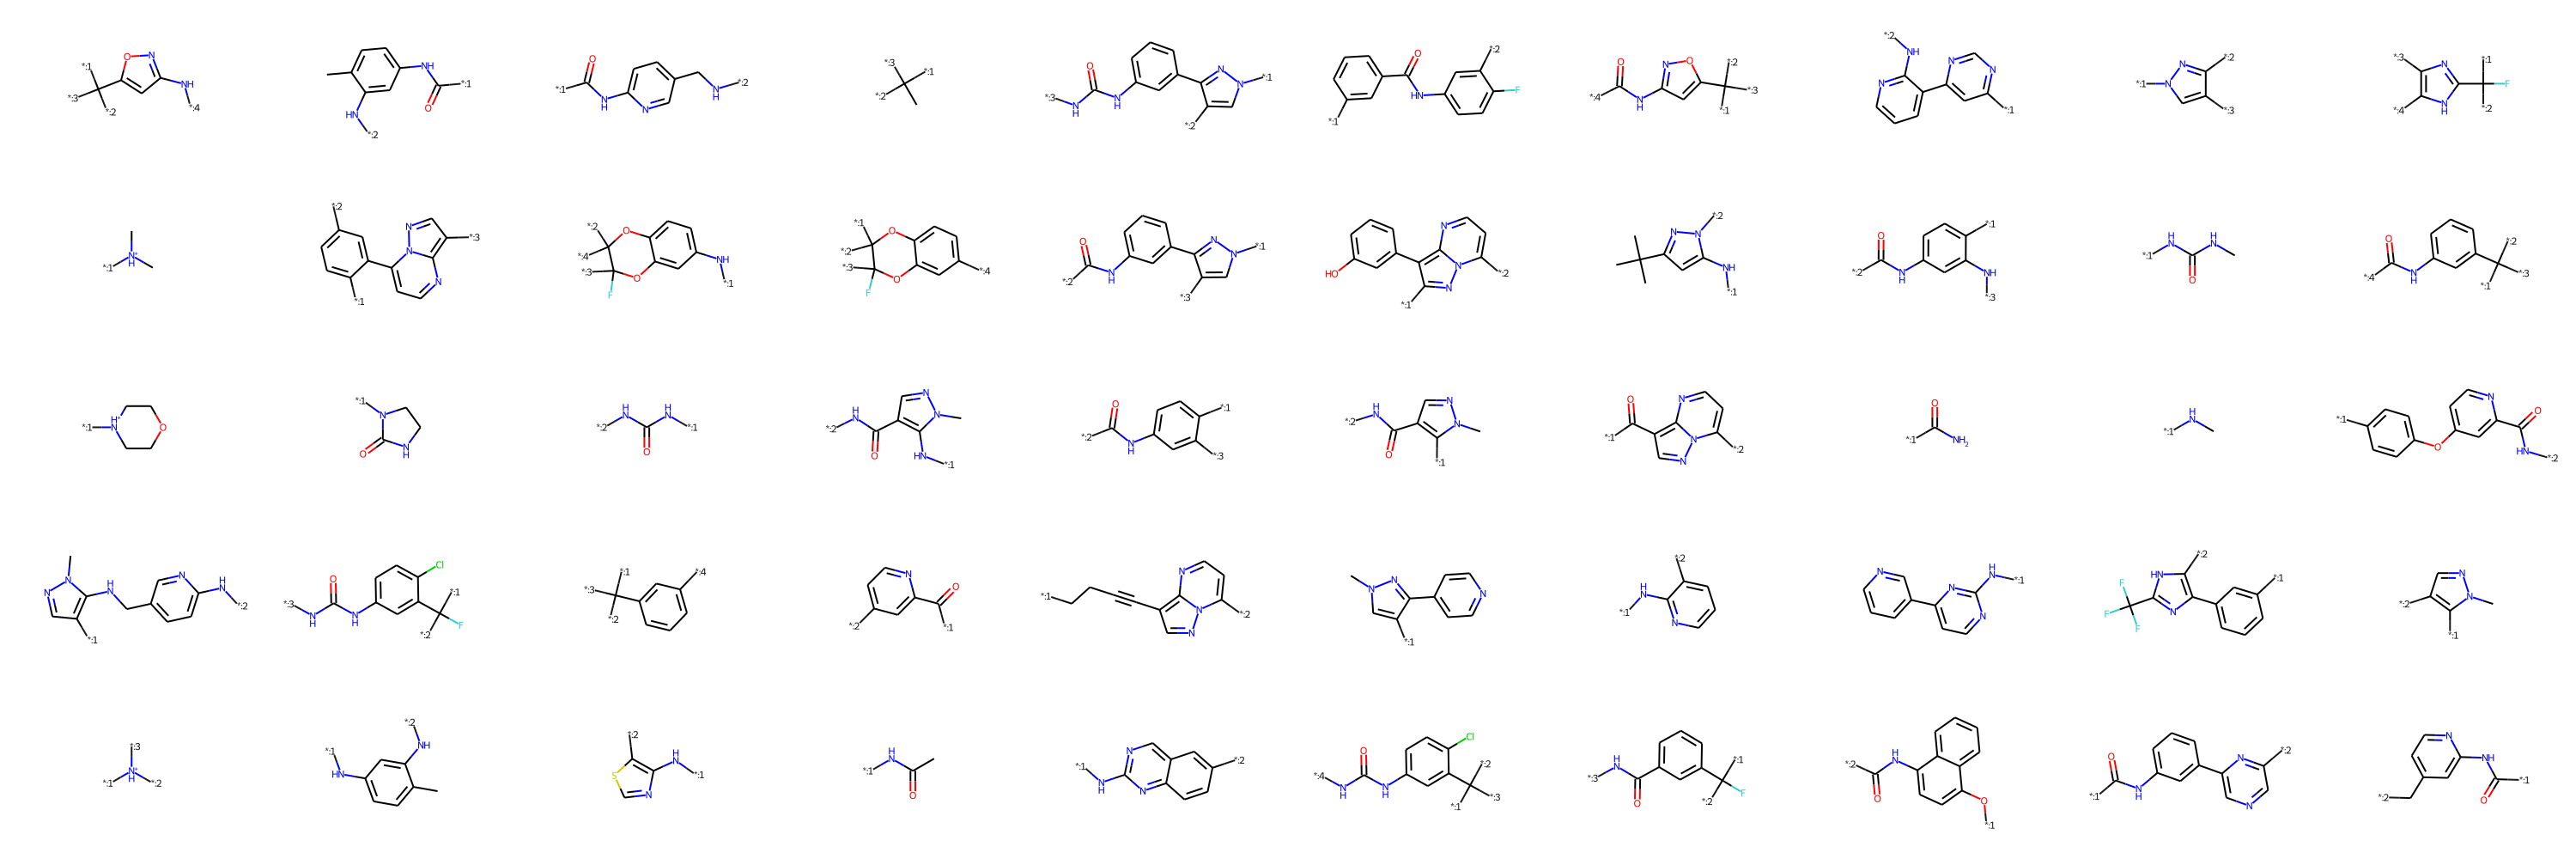

In [5]:
Draw.MolsToGridImage(frag_samples.iloc[:50].loc[frag_samples['mol']!=None]['mol'], subImgSize=(300,200),molsPerRow=10)

Now, we need to filter out the duplicates. If two fragments with same structure have different attachment sites, we leave the one that has the largest number of attachment sites.  

In [6]:
def get_num_att_points(m):
    atoms = m.GetAtoms()
    att_points = []
    for a in atoms:
        atom_idx = a.GetIdx()
        atom_symbol = a.GetSymbol()
        if atom_symbol == '*':
            att_points.append(atom_idx)
    return len(att_points)
    
att = Chem.MolFromSmiles('*')
H = Chem.MolFromSmiles('[H]')

RDKit WARNING: [00:29:15] WARNING: not removing hydrogen atom without neighbors


In [7]:
frag_samples['canon'] = frag_samples['mol'].apply(lambda m: Chem.ReplaceSubstructs(m, att, H, replaceAll=True)[0])
frag_samples['canon_smiles'] = frag_samples['canon'].apply(Chem.RemoveHs)
frag_samples['canon_smiles'] = frag_samples['canon_smiles'].apply(Chem.MolToSmiles)
frag_samples['num_att'] = frag_samples['mol'].apply(get_num_att_points)

In [8]:
_frag_samples = frag_samples[['frag', 'mol', 'canon_smiles', 'num_att']].groupby(by='canon_smiles')

We now see that there are 455 unique fragments out of 825 fragments. Fragments are grouped by their structures (without attachment points). 

In [9]:
len(_frag_samples.groups)

455

In [10]:
_frag_samples.groups

{'C': [78, 186, 238, 281, 318, 340, 384, 510, 652], 'C#C': [668], 'C#CC': [720], 'C#CCC': [190], 'C#CCCC': [785], 'C#Cc1cnn2cccnc12': [733], 'C1CC1': [459], 'C1CC2CCC(C1)N2': [457], 'C1CC[NH2+]C1': [776], 'C1COCC[NH2+]1': [20], 'C1C[NH2+]CC[NH2+]1': [151], 'C=O': [544, 598], 'CC': [3, 53, 118, 476, 606], 'CC#Cc1cnn2cccnc12': [422], 'CC(=O)Nc1cccc(-c2c[nH]cn2)c1': [508], 'CC(=O)Nc1cccc(-c2cnccn2)c1': [781], 'CC(=O)Nc1ccccc1': [525, 582], 'CC(C)(C)c1cc(N)[nH]n1': [16], 'CC(C)(C)c1cc(N)n(-c2ccccc2)n1': [377], 'CC(C)(C)c1cc(N)no1': [447], 'CC(C)(C)c1cc(NC(N)=O)[nH]n1': [399, 703], 'CC(C)(C)c1cc(NC(N)=O)no1': [101], 'CC(C)(C)c1cc(NC=O)[nH]n1': [767], 'CC(C)(C)c1cc(NC=O)no1': [285], 'CC(C)(C)c1cc[nH]n1': [694], 'CC(C)(C)c1ccn(-c2ccccc2)n1': [552], 'CC(C)(C)c1ccno1': [686], 'CC(C)C': [108], 'CC(C)c1cc(N)[nH]n1': [769], 'CC(C)c1cc(N)n(-c2ccccc2)n1': [407, 411], 'CC(C)c1cc(N)no1': [152], 'CC(C)c1cc(NC(N)=O)[nH]n1': [349, 735], 'CC(C)c1cc(NC(N)=O)no1': [774], 'CC(C)c1cc(NC=O)[nH]n1': [160], 'CC(

Let's only keep the fragments that have the most attachment sites. 

In [11]:
cleaned_frags = pd.concat([group.sort_values(by='num_att').tail(1) for name, group in _frag_samples], ignore_index=True)

Remove unsanitizable molecules. 

In [12]:
cleaned_frags['if_sane'] = cleaned_frags['mol'].apply(Chem.SanitizeMol)
cleaned_frags = cleaned_frags.loc[cleaned_frags['if_sane']==0]
print(len(cleaned_frags))

455


In [13]:
frags = cleaned_frags[['frag']]
frags.to_csv('motifs_from_zinc.txt',index=False)

We can randomly sample a fixed number of fragments and save those in txt file. 

In [14]:
frags.sample(n=80).to_csv('motifs_from_zinc_80.txt', index=False)

Sanitization error can occur during generation despite the cleaning process here. So we should manually delete the problematic motifs. 